In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import neo #Electrophys Tool
import pandas as pd
import scipy as scp
from IPython.display import HTML  # to format drop downs
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re

print(np.__version__)
print(scp.__version__)

1.26.4
1.12.0


In [2]:
%%html
<style>
  details summary {
    background-color: #ADD8E6;
    color: white;
    padding: 10px;
    border-radius: 5px;
    cursor: pointer;
    width: 155px;
  }
</style>

# Pulling the Data

In [3]:
#THE BEST one as of 21 Jan
# Description: plexon_import takes a single file and provides the left, right, and piezo data,
# as well as the familiar and novel event times

def plexon_import(filepath):

    reader = neo.PlexonIO(filepath)
    blks = reader.read()
    seg = blks[0].segments[0]
    seg.data_children
    
    #Get analog signal
    sig = seg.analogsignals[0]
    
    #Each sig index is one millisecond, but need to sort out the multiple channel issue
    sigLH = sig[:,0] #Left Hemisphere
    sigRH = sig[:,1] #Right Hemisphere
    sigPz = sig[:,2] #Piezo Data
    
    #Extract data and time series to use
    datLH = sigLH.data
    datRH = sigRH.data
    datPz = sigPz.data
    
    #Reshape data so it's just a 1-D array so it can plot
    shape = datLH.shape[0] #shape shouldn't change
    datLH = np.reshape(datLH,(shape)) 
    datRH = np.reshape(datRH,(shape)) 
    datPz = np.reshape(datPz,(shape)) 
    
    #Event_times stores the time each strobe event occured
    #Event_labels stores the label (1,2 is familiar, 0 is grey screen, 3,4 is phase shifted)
    event_times = [e.times for e in seg.events]
    event_labels = [e.labels for e in seg.events]
    
    #Smooth
    Notcha,Notchb = scp.signal.iirnotch(60,100,fs=1000)
    datLH = scp.signal.filtfilt(Notcha,Notchb,datLH)
    datRH = scp.signal.filtfilt(Notcha,Notchb,datRH)
    datPz = scp.signal.filtfilt(Notcha,Notchb,datPz)

    
    #Normalize the data to a baseline based on the mean
    base_end = int(min(event_times[3])*1000) #Convert to a millisecond unit of time
    base_start = 0 
    datLH = datLH - np.mean(datLH[base_start:base_end])
    datRH = datRH - np.mean(datRH[base_start:base_end])

    #Convcert the PCA values into Z-scores to see if that will improve performance
    datLH_mean = np.mean(datLH)
    datRH_mean = np.mean(datRH)
    datLH_std = np.std(datLH)
    datRH_std = np.std(datRH)

    datLH = (datLH - datLH_mean)/datLH_std
    datRH = (datRH - datRH_mean)/datRH_std
    
    #Change the piezo data into absolute values
    datPz = np.sqrt(datPz ** 2)
    
    #Pz Normalization
    datPz_mean = np.mean(datPz)
    datPz_std = np.std(datPz)
    datPz = (datPz - datPz_mean)/datPz_std
    

    
    event_label = event_labels[3]
    event_time = event_times[3]

    #CUT
    #Figure out which strobe event is happening
    event_familiar = []
    event_novel = []
    event_gray = []
    for event in range(0,len(event_labels[3]),1):
        if event_labels[3][event] in ['1','2']: 
            event_familiar.append(event_times[3][event])
        elif event_labels[3][event] in ['3','4']: 
            event_novel.append(event_times[3][event])
        else:
            event_gray.append(event_times[3][event])
    
    return datLH,datRH,datPz,event_label,event_time

# Stim Separated PCA

In [ ]:
#Pulling the data into an ARRAY  where each row is one epoch, with a column for each time point

import time

start = time.perf_counter()
print('STARTED ==>', start)


os.listdir("CBSC")
start_day = 1
end_day = 7

#Figure out your array size needed
#Array = [Measure,Stim Type, Day, Block, Mouse, Stim Num, Values]
Array = np.zeros([7,35,2,3,15,200,500])
#Array.fill(np.NaN)

for day in range(start_day,end_day+1,1):
    files = os.listdir("CBSC/day " + str(day) + "/")
    for file in files:
        fname = "CBSC/day " + str(day) + "/" + file #Concatenate directory with file path to be able to run the function over all days
        if os.path.splitext(fname)[1] == '.plx':
            LH_single,RH_single,Pz_single,Event_Labels,Event_Times = plexon_import(fname)         
            ##MEASURE  0 = Left Hemi, 1 = Right Hemi, 2 = Behavior       
            Day = day  
            Mouse = int(re.findall(r'\d+', file[0:9])[0])
            print(f'Day: {Day}, Mouse: {Mouse}')
            ## CHANGE UP START
            Block = 0
            for event in range(0,len(Event_Labels),1):
                if Event_Labels[event] in ['1','2']: 
                    
                    Stim_Type = 0 # Familiar!
                    Event_Time = int(Event_Times[event]*1000)
                    if Event_Time - int(Event_Times[event-1]*1000) >= 600:
                        Block = Block+1
                    #Left Hemi
                    if len(LH_single[Event_Time-100:Event_Time+400]) < 500:
                        break
                    Array[Day-1,Mouse-1,Stim_Type,0,Block,event%200] = LH_single[Event_Time-100:Event_Time+400]
                    #Right Hemi
                    if len(RH_single[Event_Time-100:Event_Time+400]) < 500:
                        break
                    Array[Day-1,Mouse-1,Stim_Type,1,Block,event%200] = RH_single[Event_Time-100:Event_Time+400]
                    #Piezo 
                    if len(Pz_single[Event_Time-100:Event_Time+400]) < 500:
                        break
                    Array[Day-1,Mouse-1,Stim_Type,2,int(event/200),event%200] = Pz_single[Event_Time-100:Event_Time+400]

                elif Event_Labels[event] in ['3','4']: 
                    Stim_Type = 1 # NOVEL!
                    Event_Time = int(Event_Times[event]*1000)
                    if Event_Time - int(Event_Times[event-1]*1000) >= 600:
                        Block = Block+1
                    #Left Hemi
                    if len(LH_single[Event_Time-100:Event_Time+400]) < 500:
                        break
                    Array[Day-1,Mouse-1,Stim_Type,0,Block,event%200] = LH_single[Event_Time-100:Event_Time+400]
                    #Right Hemi
                    if len(RH_single[Event_Time-100:Event_Time+400]) < 500:
                        break
                    Array[Day-1,Mouse-1,Stim_Type,1,Block,event%200] = RH_single[Event_Time-100:Event_Time+400]
                    #Piezo 
                    if len(Pz_single[Event_Time-100:Event_Time+400]) < 500:
                        break
                    Array[Day-1,Mouse-1,Stim_Type,2,Block,event%200] = Pz_single[Event_Time-100:Event_Time+400]
finish = time.perf_counter()
print('FINISHED ==>', round(finish - start))


In [6]:
np.save('Array_Strobe_Plexon.npy',Array)

In [3]:
Array = np.load('Array_Strobe_Plexon.npy')

In [4]:
#Masking
Array_T = Array
Array_Masked = np.mean(Array_T,axis = 6) #Stim Num
Array_Ind = Array_Masked != 0 #Everywhere that is not a null value
Array_Ind.shape

(7, 35, 2, 3, 10, 200)

In [5]:
Array_Mask = Array_T[Array_Ind,:]
Array_Mask.shape

(631764, 500)

In [6]:

#Assign the values corresponding to each Block
Stims = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[5]):
    Stims[:,:,:,:,:,i] = i
Stims = Stims[Array_Ind].astype(int)

#Assign the values corresponding to each Block
Block = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[4]):
    Block[:,:,:,:,i,:] = i
Block = Block[Array_Ind].astype(int)

#Assign the values corresponding to each Measure
Measure = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[3]):
    Measure[:,:,:,i,:,:] = i
Measure = Measure[Array_Ind].astype(int)

#Assign the values corresponding to each Stim_Type
Stim_Type = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[2]):
    Stim_Type[:,:,i,:,:,:] = i
Stim_Type = Stim_Type[Array_Ind].astype(int)

#Assign the values corresponding to each Measure
Mouse = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[1]):
    Mouse[:,i,:,:,:,:] = i
Mouse = Mouse[Array_Ind].astype(int)

#Assign the values corresponding to each Measure
Day = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[0]):
    Day[i,:,:,:,:,:] = i
Day = Day[Array_Ind].astype(int)

In [7]:
# Understanding the Masked structure
X = 200300
print(Array_Mask[X][0:10])
print(Array_T[Day[X]][Mouse[X]][Stim_Type[X]][Measure[X]][Block[X]][Stims[X]][0:10])
print(f'Array[[{Day[X]}][{Mouse[X]}][{Stim_Type[X]}][{Measure[X]}][{Block[X]}][{Stims[X]}][0:10]]')

[1.23424001 1.16979258 1.18094783 1.20855794 1.18833949 1.18038305
 1.1397954  1.18783023 1.22870271 1.25240301]
[1.23424001 1.16979258 1.18094783 1.20855794 1.18833949 1.18038305
 1.1397954  1.18783023 1.22870271 1.25240301]
Array[[1][32][0][2][1][159][0:10]]


In [8]:
pca = PCA(n_components=10)    # Specify how many components will be calculated

scaler = StandardScaler()
X = scaler.fit_transform(Array_Mask)

In [9]:
pca.fit(X);                  # Fit
DF_reduced = pca.transform(X) # calculate the component scores for the components

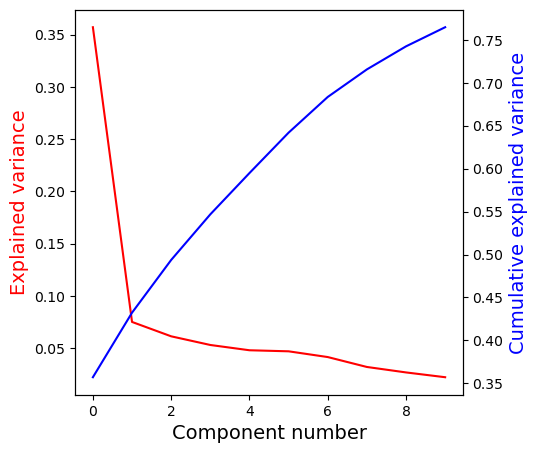

In [10]:
# Explained variance plot, in red
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pca.explained_variance_ratio_,'r')
ax.set_xlabel("Component number", fontsize=14)
ax.set_ylabel("Explained variance", color="r", fontsize=14);

# Cumulative explained variance plot, in blue
ax2=ax.twinx()
ax2.plot(np.cumsum(pca.explained_variance_ratio_),'b')
ax2.set_ylabel("Cumulative explained variance", color="blue", fontsize=14);

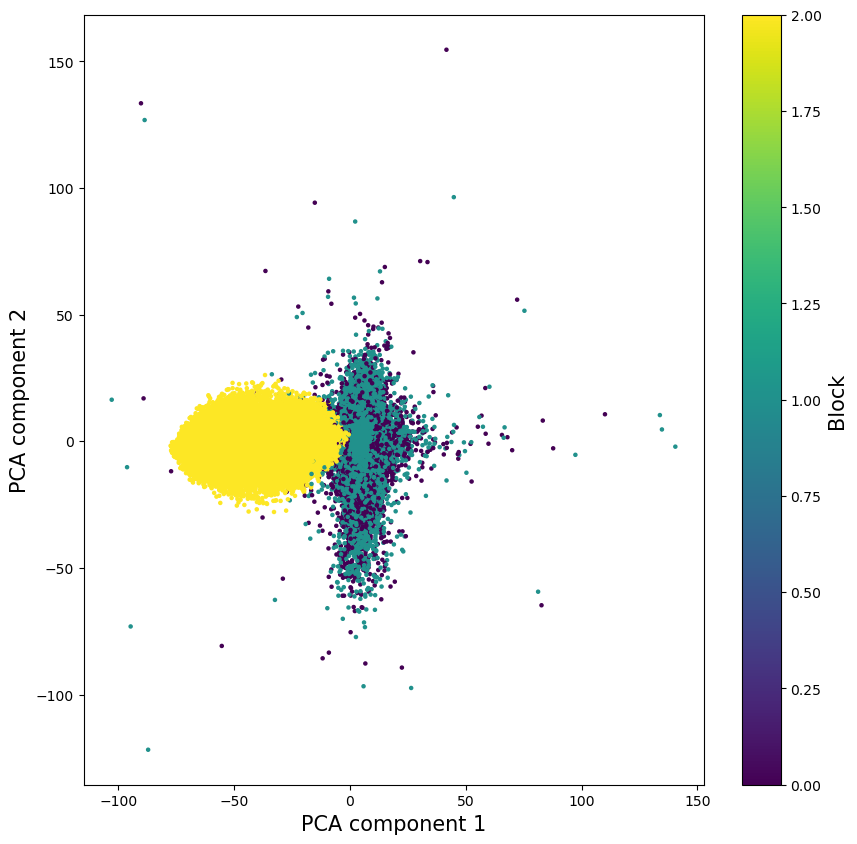

In [20]:
# choose two components to plot
cp_x = 0 # x-axis
cp_y = 1 # y-axis

fig = plt.figure(figsize=(10, 10))
plt.scatter(DF_reduced[:,cp_x], DF_reduced[:,cp_y], c=Measure, s=5)# you can vary the indices to plot a different pair of components
plt.xlabel(f'PCA component {cp_x+1}', fontsize=15) # add 1 to the label due to Python
plt.ylabel(f'PCA component {cp_y+1}', fontsize=15) # add 1 due to Python
cbar = plt.colorbar();                             # add a colorbar
cbar.set_label('Block', fontsize=15)         # add a colorbar label

# Block separated PCA

In [63]:
#Pulling the data into an ARRAY  where each row is one BLOCK of stimuli

import time

start = time.perf_counter()
print('STARTED ==>', start)

os.listdir("CBSC")
start_day = 1
end_day = 7

#Figure out your array size needed
#Array = [Measure,Stim Type, Day, Block, Mouse, Stim Num, Values]
Array = np.zeros([7,35,2,3,15,100000])
#Array.fill(np.NaN)

for day in range(start_day,end_day+1,1):
    files = os.listdir("CBSC/day " + str(day) + "/")
    for file in files:
        fname = "CBSC/day " + str(day) + "/" + file #Concatenate directory with file path to be able to run the function over all days
        if os.path.splitext(fname)[1] == '.plx':
            LH_single,RH_single,Pz_single,Event_Labels,Event_Times = plexon_import(fname)         
            ##MEASURE  0 = Left Hemi, 1 = Right Hemi, 2 = Behavior       
            Day = day  
            Mouse = int(re.findall(r'\d+', file[0:9])[0])
            print(f'Day: {Day}, Mouse: {Mouse}')
            ## CHANGE UP START
            Block = 0
            for event in range(0,len(Event_Labels),1):
                if Event_Labels[event] in ['1','2']: 
                    
                    Stim_Type = 0 # Familiar!
                    Event_Time = int(Event_Times[event]*1000)
                    if (Event_Time - int(Event_Times[event-1]*1000) >= 600) or Block == 0:
                        
                        #Left Hemi
                        if len(LH_single[Event_Time-100:Event_Time+99900]) < 100000:
                            break
                        Array[Day-1,Mouse-1,Stim_Type,0,Block] = LH_single[Event_Time-100:Event_Time+99900]
                        #Right Hemi
                        
                        Array[Day-1,Mouse-1,Stim_Type,1,Block] = RH_single[Event_Time-100:Event_Time+99900]
                        #Piezo 
                        
                        Array[Day-1,Mouse-1,Stim_Type,2,Block] = Pz_single[Event_Time-100:Event_Time+99900]
                        
                        Block = Block+1

                elif Event_Labels[event] in ['3','4']:
                    Stim_Type = 1 # NOVEL!
                    Event_Time = int(Event_Times[event]*1000)
                    if (Event_Time - int(Event_Times[event-1]*1000) >= 600) or Block == 0:
                        if len(LH_single[Event_Time-100:Event_Time+99900]) < 100000:
                            break
                        #Left Hemi
                        
                        Array[Day-1,Mouse-1,Stim_Type,0,Block] = LH_single[Event_Time-100:Event_Time+99900]
                        #Right Hemi
                        
                        Array[Day-1,Mouse-1,Stim_Type,1,Block] = RH_single[Event_Time-100:Event_Time+99900]
                        #Piezo 
                        
                        Array[Day-1,Mouse-1,Stim_Type,2,Block] = Pz_single[Event_Time-100:Event_Time+99900]
                        
                        Block = Block+1
                        
finish = time.perf_counter()
print('FINISHED ==>', round(finish - start))


STARTED ==> 1659115.297562625


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 538717.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 243.73it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 94102.97it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 1, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 594635.50it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 257.20it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116914.40it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 1, Mouse: 23


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 258.66it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 108490.08it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 78766.27it/s]


Day: 1, Mouse: 27


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 606927.71it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 268.37it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 105469.70it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 78398.21it/s]


Day: 1, Mouse: 8


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 268.89it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 110272.78it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 1, Mouse: 26


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 543706.07it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 279.56it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 151731.93it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 1, Mouse: 22


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 335065.65it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 267.58it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 84307.62it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 1, Mouse: 25


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 614871.79it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.85it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 102166.60it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93727.46it/s]


Day: 1, Mouse: 21


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 636533.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 271.77it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 135300.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 98112.37it/s]


Day: 1, Mouse: 18


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.18it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114297.34it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 1, Mouse: 20


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 641751.43it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 268.60it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 152223.61it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 1, Mouse: 24


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 474507.12it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.21it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 123556.56it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 76959.71it/s]


Day: 1, Mouse: 19


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 231.23it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 110897.56it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102300.10it/s]


Day: 1, Mouse: 17


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 629707.84it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.54it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116914.40it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 111107.39it/s]


Day: 1, Mouse: 4


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 222.32it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 152520.15it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 1, Mouse: 13


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 256.34it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113798.95it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 96978.13it/s]


Day: 1, Mouse: 33


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 628024.13it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 259.81it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 203712.94it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 1, Mouse: 12


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 266.74it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 99105.92it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 1, Mouse: 5


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 631400.60it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.82it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 125604.83it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 1, Mouse: 16


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 629707.84it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 260.77it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 86864.28it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 1, Mouse: 1


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 606927.71it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.38it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 100893.91it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 1, Mouse: 32


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 249.25it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115704.94it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 1, Mouse: 28


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 624683.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 250.88it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111318.02it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 1, Mouse: 31


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.21it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 141836.37it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 1, Mouse: 35


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 614871.79it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 244.32it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 96898.11it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 1, Mouse: 6


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 659778.16it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.14it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 118626.78it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 76959.71it/s]


Day: 1, Mouse: 15


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 555274.29it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 239.72it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112923.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 94786.53it/s]


Day: 1, Mouse: 2


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 265.77it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 99441.59it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 1, Mouse: 34


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 258.46it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112275.82it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 1, Mouse: 30


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 242.96it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113798.95it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 1, Mouse: 29


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 629707.84it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 237.82it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112008.12it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 1, Mouse: 3


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 634813.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 253.98it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 195083.91it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 1, Mouse: 14


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 250.16it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116162.72it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 1, Mouse: 7


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 265.24it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 154730.58it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 1, Mouse: 10


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 650639.96it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 260.62it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 135300.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 2, Mouse: 19


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 628024.13it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 249.75it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 158169.04it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 101680.10it/s]


Day: 2, Mouse: 20


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 250.50it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111107.39it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 2, Mouse: 18


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 606927.71it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 254.92it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 102568.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 2, Mouse: 25


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 614871.79it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 243.32it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 99821.94it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 96978.13it/s]


Day: 2, Mouse: 26


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 265.90it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115024.99it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 91180.52it/s]


Day: 2, Mouse: 8


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 616485.63it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 249.86it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 110897.56it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 2, Mouse: 27


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 603807.26it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.43it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 196553.16it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 85598.04it/s]


Day: 2, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 262.98it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114019.91it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 105517.08it/s]


Day: 2, Mouse: 14


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 258.21it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111318.02it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 2, Mouse: 21


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 629707.84it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 261.59it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 101416.68it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 2, Mouse: 3


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.72it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112706.83it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 98112.37it/s]


Day: 2, Mouse: 10


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 623026.59it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 243.27it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 107694.19it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 2, Mouse: 7


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 538717.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 243.54it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 109145.46it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 2, Mouse: 34


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 256.31it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 162885.59it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 83055.52it/s]


Day: 2, Mouse: 29


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 614871.79it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.88it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112490.91it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 85163.53it/s]


Day: 2, Mouse: 30


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.23it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 117381.82it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 2, Mouse: 6


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 636533.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 253.79it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113578.83it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 70492.50it/s]


Day: 2, Mouse: 11


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 247.30it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 136320.97it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 2, Mouse: 2


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 274.50it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 139643.89it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 2, Mouse: 24


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 614871.79it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 255.74it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 88734.80it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 2, Mouse: 15


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 565978.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 250.05it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 99652.53it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 2, Mouse: 31


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 628024.13it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 249.10it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 100591.44it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 2, Mouse: 28


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 564617.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.14it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 110480.26it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 2, Mouse: 35


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 254.81it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 52829.74it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 2, Mouse: 32


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 571486.68it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.29it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116914.40it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 87381.33it/s]


Day: 2, Mouse: 5


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 572880.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 254.20it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115933.38it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 2, Mouse: 23


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 628024.13it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 250.66it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 98606.64it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 2, Mouse: 12


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 570099.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.22it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115194.22it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 98112.37it/s]


Day: 2, Mouse: 1


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 587202.56it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.58it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 96065.86it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 2, Mouse: 16


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 523120.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 258.10it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113854.11it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 2, Mouse: 33


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 275.52it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 138572.88it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 2, Mouse: 17


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 636533.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.73it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 123297.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 96978.13it/s]


Day: 2, Mouse: 13


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 542450.40it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.10it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 143658.12it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 2, Mouse: 22


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 584281.15it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.34it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 148283.47it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86928.58it/s]


Day: 2, Mouse: 4


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 238.74it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 109196.20it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 3, Mouse: 26


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 543706.07it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 274.42it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 108993.51it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 3, Mouse: 21


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 272.70it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115876.18it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 3, Mouse: 8


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 645277.54it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 273.98it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 132029.81it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 83468.74it/s]


Day: 3, Mouse: 27


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 614871.79it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 273.73it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 100162.48it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 3, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 269.33it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 158169.04it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 100462.37it/s]


Day: 3, Mouse: 19


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 600718.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 278.44it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 107694.19it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 3, Mouse: 20


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 272.37it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114075.29it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 3, Mouse: 18


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 335065.65it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.26it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 96858.15it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102300.10it/s]


Day: 3, Mouse: 25


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 286.11it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 109399.64it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 3, Mouse: 32


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 624683.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 259.22it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 164252.46it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 84733.41it/s]


Day: 3, Mouse: 23


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 271.26it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112923.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 3, Mouse: 5


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 537485.18it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.61it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 99483.70it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 3, Mouse: 12


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 628024.13it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 281.37it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 142784.82it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 3, Mouse: 1


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 623026.59it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 250.05it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112706.83it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 3, Mouse: 16


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 638263.65it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.68it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 133911.64it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 91180.52it/s]


Day: 3, Mouse: 33


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 629707.84it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 261.29it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112869.31it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 3, Mouse: 17


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.26it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 108993.51it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 3, Mouse: 13


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 636533.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.23it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 133683.00it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86480.49it/s]


Day: 3, Mouse: 4


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 286.76it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112869.31it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102300.10it/s]


Day: 3, Mouse: 22


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 283.35it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116392.98it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86928.58it/s]


Day: 3, Mouse: 14


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 636533.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.71it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 129553.79it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 3, Mouse: 3


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 255.44it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113633.78it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 81840.08it/s]


Day: 3, Mouse: 10


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 650639.96it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 257.15it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116392.98it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 3, Mouse: 7


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 565978.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 242.54it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 133001.71it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 3, Mouse: 34


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 606927.71it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.01it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 61487.18it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 3, Mouse: 30


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.75it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 88069.38it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 3, Mouse: 29


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 469762.05it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 235.53it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 149320.42it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 3, Mouse: 6


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 259.95it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111370.80it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 3, Mouse: 11


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.60it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 100893.91it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 91180.52it/s]


Day: 3, Mouse: 24


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 610080.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 255.57it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 130489.46it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 3, Mouse: 2


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 634813.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.22it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 110636.37it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 3, Mouse: 15


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 532610.03it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.58it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 130200.12it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 85163.53it/s]


Day: 3, Mouse: 28


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.15it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 128772.49it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 3, Mouse: 31


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.23it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 160437.86it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 3, Mouse: 35


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 623026.59it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 257.11it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 104670.69it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 4, Mouse: 33


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.23it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111529.45it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 4, Mouse: 13


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.43it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114075.29it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 4, Mouse: 4


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 560575.24it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 249.16it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113688.78it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 91180.52it/s]


Day: 4, Mouse: 22


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 553964.68it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 280.37it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 127583.39it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 4, Mouse: 17


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 571486.68it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 228.92it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 157744.14it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 4, Mouse: 32


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 529011.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 219.24it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 83320.69it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 65793.00it/s]


Day: 4, Mouse: 1


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 474507.12it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 244.44it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 160547.52it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 94786.53it/s]


Day: 4, Mouse: 16


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 240.52it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 96698.65it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 4, Mouse: 23


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 352145.46it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.14it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 93022.19it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 4, Mouse: 5


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 261560.16it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 240.56it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 75258.26it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 61680.94it/s]


Day: 4, Mouse: 12


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.41it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 118866.91it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 4, Mouse: 24


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 585738.21it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 249.42it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 83084.90it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 76608.29it/s]


Day: 4, Mouse: 2


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 508400.48it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 239.72it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 142871.67it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 4, Mouse: 15


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 187305.44it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 190.97it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112008.12it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 53261.00it/s]


Day: 4, Mouse: 6


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 529011.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.90it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 97018.18it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 4, Mouse: 11


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 570099.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 265.76it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112706.83it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 96978.13it/s]


Day: 4, Mouse: 35


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 547508.21it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 228.81it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 97218.97it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 91180.52it/s]


Day: 4, Mouse: 31


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.25it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115933.38it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 4, Mouse: 28


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 548787.44it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 240.50it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 143132.86it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 96978.13it/s]


Day: 4, Mouse: 10


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 570099.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.48it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 119168.45it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 4, Mouse: 7


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.07it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111107.39it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 4, Mouse: 14


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 250.44it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 135612.60it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 4, Mouse: 3


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 555274.29it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 258.67it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 129411.03it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 4, Mouse: 29


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.00it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 109399.64it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 91180.52it/s]


Day: 4, Mouse: 30


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 267.29it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113414.30it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 98112.37it/s]


Day: 4, Mouse: 34


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.32it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 130489.46it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 4, Mouse: 27


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 234.54it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 81386.36it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 4, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 572880.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.11it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 92728.39it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 64527.75it/s]


Day: 4, Mouse: 26


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 234.60it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116914.40it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86480.49it/s]


Day: 4, Mouse: 8


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 253.67it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 142093.78it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 4, Mouse: 21


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 610080.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.80it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 71631.91it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 94786.53it/s]


Day: 4, Mouse: 18


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.69it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112923.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86480.49it/s]


Day: 4, Mouse: 25


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.19it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 156067.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 4, Mouse: 19


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 265.93it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 106088.99it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 4, Mouse: 20


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 623026.59it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.74it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 102747.60it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 5, Mouse: 2


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 271.54it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 135300.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 5, Mouse: 24


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 613266.38it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 268.97it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 135847.90it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 5, Mouse: 15


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.27it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116624.14it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 5, Mouse: 6


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 265.57it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 160877.41it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86928.58it/s]


Day: 5, Mouse: 11


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 584281.15it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 275.25it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 90338.86it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 5, Mouse: 35


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 643509.65it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 266.90it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116392.98it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 5, Mouse: 28


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 616485.63it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 261.05it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114075.29it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 5, Mouse: 31


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 643509.65it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 259.89it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 103883.69it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 85163.53it/s]


Day: 5, Mouse: 10


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 559240.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 257.06it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 147260.83it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 5, Mouse: 7


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 495529.59it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 242.92it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 44944.70it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 42581.77it/s]


Day: 5, Mouse: 14


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 652447.29it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 243.09it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 93503.59it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 5, Mouse: 3


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 533820.51it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.26it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 168615.24it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 84733.41it/s]


Day: 5, Mouse: 30


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 643509.65it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.97it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 156378.84it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 5, Mouse: 29


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 614871.79it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 237.32it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 87773.18it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 81442.80it/s]


Day: 5, Mouse: 34


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 462364.22it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 229.29it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 94291.86it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 98112.37it/s]


Day: 5, Mouse: 33


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 260.57it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112923.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 5, Mouse: 21


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 606927.71it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 255.31it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114075.29it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 5, Mouse: 13


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 288.21it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 98565.26it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102300.10it/s]


Day: 5, Mouse: 22


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 244.26it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 99991.92it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 5, Mouse: 4


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 548787.44it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 254.83it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 75185.99it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 5, Mouse: 17


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 527822.53it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 236.47it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 108140.43it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 98112.37it/s]


Day: 5, Mouse: 32


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 600718.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 247.29it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 96539.67it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 5, Mouse: 1


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 301129.52it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 139.50it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 77136.63it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 83468.74it/s]


Day: 5, Mouse: 16


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 518501.16it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 233.13it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 97420.58it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86928.58it/s]


Day: 5, Mouse: 5


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 572880.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 240.30it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 101812.32it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 5, Mouse: 23


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 610080.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 282.59it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 66256.99it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 85163.53it/s]


Day: 5, Mouse: 12


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 510610.92it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 239.79it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116162.72it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 5, Mouse: 18


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 508400.48it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 233.67it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 68880.07it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 5, Mouse: 25


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 581388.67it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.41it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 134679.49it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 100462.37it/s]


Day: 5, Mouse: 19


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 564617.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.58it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112437.06it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 94786.53it/s]


Day: 5, Mouse: 20


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.05it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111318.02it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 5, Mouse: 27


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 539956.38it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 243.22it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114075.29it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 5, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 600718.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 242.20it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 99273.47it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 5, Mouse: 26


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 259.72it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 106618.71it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 5, Mouse: 8


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 636533.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.01it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 97541.95it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 6, Mouse: 16


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 244.01it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114297.34it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 6, Mouse: 1


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.80it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 132701.14it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 85163.53it/s]


Day: 6, Mouse: 12


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 474507.12it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 237.22it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111529.45it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 6, Mouse: 5


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 381300.36it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 212.08it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 109399.64it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102300.10it/s]


Day: 6, Mouse: 23


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 553964.68it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 243.28it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 106041.09it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86928.58it/s]


Day: 6, Mouse: 32


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.14it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114241.74it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 6, Mouse: 22


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 603807.26it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 243.43it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 128701.93it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 6, Mouse: 4


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.24it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113141.15it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 6, Mouse: 13


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 523120.32it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 271.98it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 160000.70it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 6, Mouse: 17


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.80it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 117206.10it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 6, Mouse: 33


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.42it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 149701.10it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 6, Mouse: 29


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 571486.68it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 282.02it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 108140.43it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 91180.52it/s]


Day: 6, Mouse: 30


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 600718.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.72it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115194.22it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 6, Mouse: 34


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 216879.99it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 182.86it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 75065.84it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 85163.53it/s]


Day: 6, Mouse: 7


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 234.77it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 105897.67it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 6, Mouse: 10


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 233.12it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 90165.46it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 6, Mouse: 3


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 564617.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 263.97it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 94481.51it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 6, Mouse: 14


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 584281.15it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.37it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 126144.48it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 6, Mouse: 35


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.66it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 130200.12it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 100462.37it/s]


Day: 6, Mouse: 21


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 542450.40it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 247.16it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 139643.89it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 6, Mouse: 31


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 555274.29it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 232.18it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 151340.87it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 6, Mouse: 28


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.11it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 101636.10it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102300.10it/s]


Day: 6, Mouse: 15


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 199.34it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 83557.82it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 6, Mouse: 2


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 509503.31it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 213.97it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 97380.19it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 87381.33it/s]


Day: 6, Mouse: 24


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 240.41it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 101856.47it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 6, Mouse: 11


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 244.10it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 75282.38it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 83055.52it/s]


Day: 6, Mouse: 6


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 258964.75it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 183.37it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 107497.04it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 6, Mouse: 8


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 610080.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 273.60it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115250.75it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 6, Mouse: 26


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 553964.68it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 274.31it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114075.29it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 6, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 261.87it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111794.87it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 6, Mouse: 27


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 571486.68it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 263.10it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 198546.93it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 6, Mouse: 20


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 623026.59it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 257.58it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 197877.86it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86928.58it/s]


Day: 6, Mouse: 19


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 610080.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 265.46it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113141.15it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 6, Mouse: 25


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 265.02it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 136320.97it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 6, Mouse: 18


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 584281.15it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 127.44it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 71588.24it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 7, Mouse: 18


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 122.80it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116450.68it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 7, Mouse: 26


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 594635.50it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 123.73it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 107300.60it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 7, Mouse: 14


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 602259.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 124.27it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 63072.24it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 7, Mouse: 3


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 126.21it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 98400.09it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 7, Mouse: 17


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 542450.40it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 125.69it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 135926.52it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 7, Mouse: 34


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 553964.68it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 127.66it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 110688.51it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 7, Mouse: 29


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 572880.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 128.11it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 82241.25it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 7, Mouse: 25


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 126.13it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 108140.43it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 7, Mouse: 13


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 126.65it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111107.39it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 7, Mouse: 4


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 616485.63it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 124.10it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 109808.80it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 101680.10it/s]


Day: 7, Mouse: 30


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 125.25it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 116162.72it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 7, Mouse: 8


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 603807.26it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 125.40it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 89889.41it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 94786.53it/s]


Day: 7, Mouse: 21


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 127.72it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 112923.57it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 94786.53it/s]


Day: 7, Mouse: 22


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 610080.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 123.83it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 129055.51it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 83886.08it/s]


Day: 7, Mouse: 10


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 123.41it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 123556.56it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 7, Mouse: 7


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 570099.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 126.07it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 109196.20it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 7, Mouse: 33


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 119.55it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 76483.56it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 72944.42it/s]


Day: 7, Mouse: 19


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 131.01it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 89037.54it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 7, Mouse: 27


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 544967.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 128.53it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 107941.65it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 7, Mouse: 15


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 585738.21it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 130.36it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 120948.00it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 7, Mouse: 2


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 616485.63it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 110.51it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 143220.14it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 7, Mouse: 16


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 565978.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 124.33it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111318.02it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 7, Mouse: 35


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 125.02it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 98235.48it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 7, Mouse: 1


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 125.74it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114688.00it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 91180.52it/s]


Day: 7, Mouse: 28


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 628024.13it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 124.08it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 100034.51it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 7, Mouse: 24


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 287.71it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 132401.93it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 7, Mouse: 12


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 126.46it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111107.39it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 7, Mouse: 31


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 119.12it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 134371.30it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 94786.53it/s]


Day: 7, Mouse: 5


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 564617.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 124.58it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 97907.89it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 7, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 127.01it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 94901.42it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 7, Mouse: 20


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 588674.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 126.92it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 80136.82it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 7, Mouse: 23


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 124.83it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 100505.36it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102300.10it/s]


Day: 7, Mouse: 11


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 600718.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 127.73it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 102612.94it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 7, Mouse: 32


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 578524.69it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 123.47it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 106425.48it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 7, Mouse: 6
FINISHED ==> 397


In [64]:
#Masking
Array_T = Array
Array_Masked = np.mean(Array_T,axis = 5) 
Array_Ind = Array_Masked != 0 #Everywhere that is not a null value
Array_Ind.shape

(7, 35, 2, 3, 15)

In [65]:
Array_Mask = Array_T[Array_Ind,:]
Array_Mask.shape

(4041, 100000)

In [66]:

#Assign the values corresponding to each Block
Block = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[4]):
    Block[:,:,:,:,i] = i
Block = Block[Array_Ind].astype(int)

#Assign the values corresponding to each Measure
Measure = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[3]):
    Measure[:,:,:,i,:] = i
Measure = Measure[Array_Ind].astype(int)

#Assign the values corresponding to each Stim_Type
Stim_Type = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[2]):
    Stim_Type[:,:,i,:,:] = i
Stim_Type = Stim_Type[Array_Ind].astype(int)

#Assign the values corresponding to each Measure
Mouse = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[1]):
    Mouse[:,i,:,:,:] = i
Mouse = Mouse[Array_Ind].astype(int)

#Assign the values corresponding to each Measure
Day = np.zeros(Array_Ind.shape)
for i in range(Array_T.shape[0]):
    Day[i,:,:,:,:] = i
Day = Day[Array_Ind].astype(int)

In [67]:
# Understanding the Masked structure
X = 500
print(Array_Mask[X][0:10])
print(Array_T[Day[X]][Mouse[X]][Stim_Type[X]][Measure[X]][Block[X]][0:10])
print(f'Array[[{Day[X]}][{Mouse[X]}][{Stim_Type[X]}][{Measure[X]}][{Block[X]}][0:10]]')

[1.22539982 1.28924283 1.50031372 1.68296817 1.85591309 1.52723417
 1.24199411 1.11376305 1.09937646 1.17576819]
[1.22539982 1.28924283 1.50031372 1.68296817 1.85591309 1.52723417
 1.24199411 1.11376305 1.09937646 1.17576819]
Array[[0][34][0][1][0][0:10]]


In [68]:
pca = PCA(n_components=10)    # Specify how many components will be calculated

scaler = StandardScaler()
X = scaler.fit_transform(Array_Mask)

In [ ]:
pca.fit(X);                  # Fit
DF_reduced = pca.transform(X) # calculate the component scores for the components

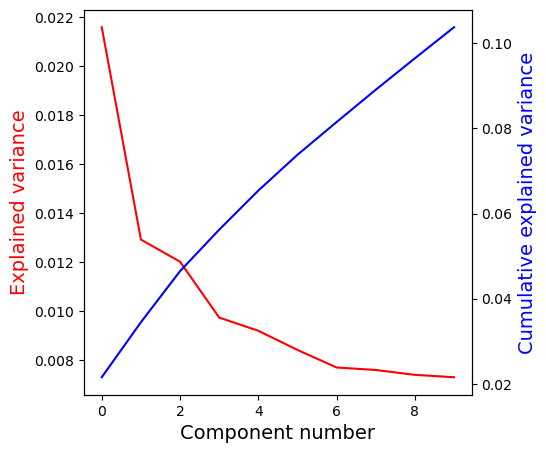

In [54]:
# Explained variance plot, in red
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pca.explained_variance_ratio_,'r')
ax.set_xlabel("Component number", fontsize=14)
ax.set_ylabel("Explained variance", color="r", fontsize=14);

# Cumulative explained variance plot, in blue
ax2=ax.twinx()
ax2.plot(np.cumsum(pca.explained_variance_ratio_),'b')
ax2.set_ylabel("Cumulative explained variance", color="blue", fontsize=14);

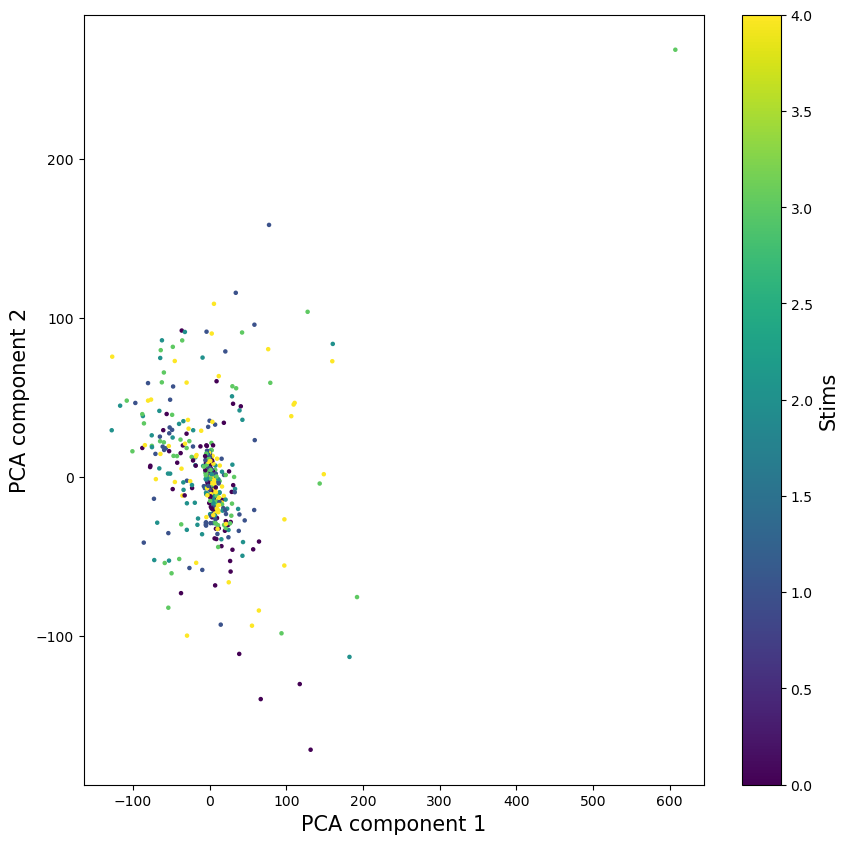

In [57]:
# choose two components to plot
cp_x = 0 # x-axis
cp_y = 1 # y-axis

fig = plt.figure(figsize=(10, 10))
plt.scatter(DF_reduced[:,cp_x], DF_reduced[:,cp_y], c=Block, s=5)# you can vary the indices to plot a different pair of components
plt.xlabel(f'PCA component {cp_x+1}', fontsize=15) # add 1 to the label due to Python
plt.ylabel(f'PCA component {cp_y+1}', fontsize=15) # add 1 due to Python
cbar = plt.colorbar();                             # add a colorbar
cbar.set_label('Stims', fontsize=15)         # add a colorbar label

# Trash

In [ ]:
# Threading Test for speeding up things

import threading
import requests
import time

start = time.perf_counter()
print('STARTED ==>', start)

os.listdir("CBSC")
start_day = 1
end_day = 2

#Figure out your array size needed
#Array = [Day, Mouse, Stim Type, Measure, Block, Stim Num, Values]
Array = np.zeros([7,35,2,3,20,200,500])
#Array.fill(np.NaN)
num = 0
threads = []
for day in range(start_day,end_day+1,1):
    files = os.listdir("CBSC/day " + str(day) + "/")
    for file in files:
        fname = "CBSC/day " + str(day) + "/" + file #Concatenate directory with file path to be able to run the function over all days
        if os.path.splitext(fname)[1] == '.plx':
            t = threading.Thread(target = plexon_import,args = [fname])
            t.start()
            threads.append(t)
            num += 1
            #LH_single,RH_single,Pz_single,Event_Labels,Event_Times = plexon_import(fname)         
            ##MEASURE  0 = Left Hemi, 1 = Right Hemi, 2 = Behavior       
            Day = day  
            Mouse = int(re.findall(r'\d+', file[0:9])[0])
            print(f'Day: {Day}, Mouse: {Mouse}')
            
            ## CHANGE UP START
            for event in range(0,len(Event_Labels),1):
                if Event_Labels[event] in ['1','2']: 
                    
                    Stim_Type = 0 # Familiar!
                    Event_Time = int(Event_Times[event]*1000)
                    #Left Hemi
                    Array[Day-1,Mouse-1,Stim_Type,0,int(event/200),event%200] = LH_single[Event_Time-100:Event_Time+400]
                    #Right Hemi
                    Array[Day-1,Mouse-1,Stim_Type,1,int(event/200),event%200] = RH_single[Event_Time-100:Event_Time+400]
                    #Piezo 
                    #Array[Day-1,Mouse-1,Stim_Type,2,int(event/200),event%200] = Pz_single[Event_Time-100:Event_Time+400]

                elif Event_Labels[event] in ['3','4']: 
                    Stim_Type = 1 # NOVEL!
                    Event_Time = int(Event_Times[event]*1000)
                    
                    #Left Hemi
                    Array[Day-1,Mouse-1,Stim_Type,0,int(event/200),event%200] = LH_single[Event_Time-100:Event_Time+400]
                    #Right Hemi
                    Array[Day-1,Mouse-1,Stim_Type,1,int(event/200),event%200] = RH_single[Event_Time-100:Event_Time+400]
                    #Piezo 
                    #Array[Day-1,Mouse-1,Stim_Type,2,int(event/200),event%200] = Pz_single[Event_Time-100:Event_Time+400]
            for thread in threads:
                thread.join()

finish = time.perf_counter()
print('FINISHED ==>', round(finish - start))



In [36]:
#Pulling the data into an array within an array format, doesn't work for PCA :(

os.listdir("CBSC")
start_day = 1
end_day = 2

#Data Framington
columns = np.concatenate((['Measure','Day','Mouse','Block','Stim Num', 'Stim Type', 'Stim Time'],np.arange(500)))
DF = pd.DataFrame()
ind = 0
for day in range(start_day,end_day+1,1):
    files = os.listdir("CBSC/day " + str(day) + "/")

    #Creates three files, one for each reading type, split for each file (mouse)
    for file in files:
        fname = "CBSC/day " + str(day) + "/" + file #Concatenate directory with file path to be able to run the function over all days
        if os.path.splitext(fname)[1] == '.plx':
            LH_single,RH_single,Pz_single,Event_Labels,Event_Times = plexon_import(fname)         
            ##MEASURE  0 = Left Hemi, 1 = Right Hemi, 2 = Behavior       
            Day = day  
            Mouse = int(re.findall(r'\d+', file[0:9])[0])
            print(f'Day: {Day}, Mouse: {Mouse}')

            ## CHANGE UP START
            for event in range(0,len(Event_Labels),1):
                if Event_Labels[event] in ['1','2']: 
                    Stim_Type = 0 # Familiar!
                    Event_Time = int(Event_Times[event]*1000)
                    Value_Series = pd.DataFrame(data = [np.concatenate(([0, Day, Mouse, int(event/200)+1 , event%200, Stim_Type, Event_Time], LH_single[Event_Time-100:Event_Time+400]))]\
                                                         #,[1, Day, Mouse ,int(event/200)+1 ,event%200, Stim_Type, Event_Time, RH_single[Event_Time-100:Event_Time+400]]\
                                                         #,[2, Day, Mouse ,int(event/200)+1 ,event%200, Stim_Type, Event_Time, Pz_single[Event_Time-100:Event_Time+400]]]\
                                                        , columns = columns, index = [ind,ind+1,ind+2])
                    DF = pd.concat([DF,Value_Series],ignore_index=False)
                    ind = ind+3
                elif Event_Labels[event] in ['3','4']: 
                    Stim_Type = 1 # NOVEL!
                    Event_Time = int(Event_Times[event]*1000)
                    Value_Series = pd.DataFrame(data = [[0, Day, Mouse, int(event/200)+1 , event%200, Stim_Type, Event_Time, LH_single[Event_Time-100:Event_Time+400]]\
                                                        ,[1, Day, Mouse ,int(event/200)+1 ,event%200, Stim_Type, Event_Time, RH_single[Event_Time-100:Event_Time+400]]\
                                                        ,[2, Day, Mouse ,int(event/200)+1 ,event%200, Stim_Type, Event_Time, Pz_single[Event_Time-100:Event_Time+400]]]\
                                                        , columns = columns, index = [ind,ind+1,ind+2])
                    DF = pd.concat([DF,Value_Series],ignore_index=False)
                    ind = ind+3



Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 572880.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 243.25it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 29879.28it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 1, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 603807.26it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 226.23it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115250.75it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 1, Mouse: 23


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 577103.25it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 246.22it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 111107.39it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 1, Mouse: 27


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 650639.96it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.51it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113909.32it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 1, Mouse: 8


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 629707.84it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 241.03it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 103837.76it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 1, Mouse: 26


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 543706.07it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 230.47it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 122461.43it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 1, Mouse: 22


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 608500.06it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 242.10it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 107892.06it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 108240.10it/s]


Day: 1, Mouse: 25


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 578524.69it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.08it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 99949.37it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 1, Mouse: 21


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 643509.65it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 252.56it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 110636.37it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 1, Mouse: 18


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 657930.04it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 283.00it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 97541.95it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 1, Mouse: 20


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 258.25it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 127514.13it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 1, Mouse: 24


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 621378.37it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 248.25it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 102389.29it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86928.58it/s]


Day: 1, Mouse: 19


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 538717.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 274.27it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 105469.70it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 1, Mouse: 17


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 634813.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 264.78it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 153016.95it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 1, Mouse: 4


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 533820.51it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 258.47it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 142093.78it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 88768.34it/s]


Day: 1, Mouse: 13


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 624683.57it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 257.60it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 115024.99it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 84733.41it/s]


Day: 1, Mouse: 33


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 636533.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 239.77it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 160000.70it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 89240.51it/s]


Day: 1, Mouse: 12


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 412071.97it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 264.99it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 94557.58it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 1, Mouse: 5


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 512840.66it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 156.80it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 102166.60it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 84733.41it/s]


Day: 1, Mouse: 16


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 616485.63it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 254.85it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 93466.38it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 1, Mouse: 1


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 628024.13it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 276.38it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 104067.80it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102300.10it/s]


Day: 1, Mouse: 32


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 590153.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 270.67it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 108741.21it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86480.49it/s]


Day: 1, Mouse: 28


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 610080.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 275.56it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 110897.56it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 98112.37it/s]


Day: 1, Mouse: 31


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 610080.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 250.77it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 110480.26it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 81840.08it/s]


Day: 1, Mouse: 35


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 616485.63it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 269.44it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 114297.34it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|█████████████████| 4/4 [00:00<00:00, 102927.71it/s]


Day: 1, Mouse: 6


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 578524.69it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 258.48it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 178888.82it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 1, Mouse: 15


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 636533.94it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 270.40it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 102747.60it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 83468.74it/s]


Day: 1, Mouse: 2


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 629707.84it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 261.29it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 124737.67it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 76608.29it/s]


Day: 1, Mouse: 34


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 652447.29it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 262.78it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 106861.25it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 1, Mouse: 30


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 584281.15it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 274.31it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 137357.32it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 1, Mouse: 29


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 582831.33it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 280.79it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 108993.51it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 98112.37it/s]


Day: 1, Mouse: 3


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 266.77it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 173471.95it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 92691.80it/s]


Day: 1, Mouse: 14


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 628024.13it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.11it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 93764.88it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 1, Mouse: 7


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 667275.64it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 266.43it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 105849.94it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 1, Mouse: 10


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 623026.59it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 258.85it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 95209.17it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 97541.95it/s]


Day: 2, Mouse: 19


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 572880.55it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 257.77it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 72182.24it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 2, Mouse: 20


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 277.45it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 113578.83it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 65281.00it/s]


Day: 2, Mouse: 18


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 564617.85it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 255.56it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 93990.01it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 83055.52it/s]


Day: 2, Mouse: 25


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 610080.58it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 260.75it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 103108.44it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 76959.71it/s]


Day: 2, Mouse: 26


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 643509.65it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 273.80it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 124737.67it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 95325.09it/s]


Day: 2, Mouse: 8


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 462364.22it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 261.21it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 93802.33it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 90687.65it/s]


Day: 2, Mouse: 27


Finalizing data blocks for type 1: 100%|█████| 56/56 [00:00<00:00, 81754.62it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 209.86it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 84066.22it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 85598.04it/s]


Day: 2, Mouse: 9


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 606927.71it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 267.00it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 124144.30it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 99864.38it/s]


Day: 2, Mouse: 14


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 100162.48it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 245.90it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 88734.80it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 93206.76it/s]


Day: 2, Mouse: 21


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 543706.07it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 251.04it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 38304.15it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 81442.80it/s]


Day: 2, Mouse: 3


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 596144.73it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 269.83it/s]

Parsing signal channels: 100%|███████████████| 56/56 [00:00<00:00, 99441.59it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 76959.71it/s]


Day: 2, Mouse: 10


Finalizing data blocks for type 1: 100%|████| 56/56 [00:00<00:00, 553964.68it/s]

Finalizing data blocks for type 4: 100%|█████████| 4/4 [00:00<00:00, 260.25it/s]

Parsing signal channels: 100%|██████████████| 56/56 [00:00<00:00, 131438.74it/s]
Parsing spike channels: 0it [00:00, ?it/s]
Parsing event channels: 100%|██████████████████| 4/4 [00:00<00:00, 86928.58it/s]


Day: 2, Mouse: 7


KeyboardInterrupt: 

In [ ]:
#Pulling the data into a dataframe where each row is one time point within the epoch 
#TAKES WAY TOO LONG

os.listdir("CBSC")
start_day = 1
end_day = 1

#Data Framington
columns = ['Measure','Day','Mouse','Block','Stim Num', 'Stim Type', 'Stim Time', 'Values']
DF = pd.DataFrame()
ind = 0
for day in range(start_day,end_day+1,1):
    files = os.listdir("CBSC/day " + str(day) + "/")

    #Creates three files, one for each reading type, split for each file (mouse)
    for file in files:
        fname = "CBSC/day " + str(day) + "/" + file #Concatenate directory with file path to be able to run the function over all days
        if os.path.splitext(fname)[1] == '.plx':
            LH_single,RH_single,Pz_single,Event_Labels,Event_Times = plexon_import(fname)         
            ##MEASURE  0 = Left Hemi, 1 = Right Hemi, 2 = Behavior       
            Day = day  
            Mouse = int(re.findall(r'\d+', file[0:9])[0])
            print(f'Day: {Day}, Mouse: {Mouse}')

            ## CHANGE UP START
            for event in range(0,len(Event_Labels),1):
                if Event_Labels[event] in ['1','2']: 
                    Stim_Type = 0 # Familiar!
                    Event_Time = int(Event_Times[event]*1000)
                    #Left Hemi
                    Value_Series = DF_Column_Fill(LH_single,0, Event_Time, Day, Mouse, event, Stim_Type, ind, columns)                                
                    DF = pd.concat([DF,Value_Series],ignore_index=False)
                    #Right Hemi
                    Value_Series = DF_Column_Fill(RH_single,1, Event_Time, Day, Mouse, event, Stim_Type, ind+500, columns)                                
                    DF = pd.concat([DF,Value_Series],ignore_index=False)
                    #Piezo
                    Value_Series = DF_Column_Fill(Pz_single,2, Event_Time, Day, Mouse, event, Stim_Type, ind+1000, columns)                                
                    DF = pd.concat([DF,Value_Series],ignore_index=False)
                    ind = ind+1500
                elif Event_Labels[event] in ['3','4']: 
                    Stim_Type = 1 # NOVEL!
                    Event_Time = int(Event_Times[event]*1000)
                    #Left Hemi
                    Value_Series = DF_Column_Fill(LH_single,0, Event_Time, Day, Mouse, event, Stim_Type, ind, columns)                                
                    DF = pd.concat([DF,Value_Series],ignore_index=False)
                    #Right Hemi
                    Value_Series = DF_Column_Fill(RH_single,1, Event_Time, Day, Mouse, event, Stim_Type, ind+500, columns)                                
                    DF = pd.concat([DF,Value_Series],ignore_index=False)
                    #Piezo
                    Value_Series = DF_Column_Fill(Pz_single,2, Event_Time, Day, Mouse, event, Stim_Type, ind+1000, columns)                                
                    DF = pd.concat([DF,Value_Series],ignore_index=False)
                    ind = ind+1500



In [7]:
def DF_Column_Fill(Data, Measure, Event_Time, Day, Mouse, event, Stim_Type, ind, columns):
    DF = pd.DataFrame(columns = columns,index = np.arange(ind,ind+500))
    DF['Time'] = np.arange(Event_Time-100,Event_Time+400)
    DF['Values'] = Data[Event_Time-100:Event_Time+400]
    DF['Measure'] = Measure
    DF['Day'] = Day
    DF['Mouse'] = Mouse
    DF['Block'] = int(event/200)+1
    DF['Stim Num'] = event%200
    DF['Stim Type'] = Stim_Type
    DF['Stim Time'] = Event_Time
    
    return DF